![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Project: SVM CLASSIFICATION
### Noemi Lucchi

In [41]:
# Import necessary packages 
import pandas as pd
import numpy as np
import seaborn as sns
import nltk 
import re
import random
import time
import warnings

import sklearn
import imblearn
import matplotlib
import lightgbm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from imblearn.combine import SMOTETomek  
import matplotlib.pyplot as plt 
import lightgbm as lgb
import xgboost as xgb

# Suppress warnings
warnings.filterwarnings('ignore')

In [42]:
# Versions of the imported packages to ensure code reproducibility
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"nltk: {nltk.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"imblearn: {imblearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"lightgbm: {lightgbm.__version__}")
print(f"xgboost: {xgb.__version__}")

pandas: 2.2.3
numpy: 1.26.4
seaborn: 0.12.2
nltk: 3.9.1
sklearn: 1.6.1
imblearn: 0.13.0
matplotlib: 3.10.0
lightgbm: 4.5.0
xgboost: 2.1.4


In [ ]:
# Load train and test datasets
data = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/Deep Learning/project1/data/mimic_train.csv')
test = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/Deep Learning/project1/data/mimic_X_test.csv')
diagnoses = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/Deep Learning/project1/data/MIMIC_diagnoses.csv')
text = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/Deep Learning/project1/data/MIMIC_metadata_diagnose.csv')

# Duplicates in identifiers:

### Mimic_train
- `subject_id` identifies a unique patient, who can be hospitalized multiple times; 
- `hadm_id` represents a hospitalization identifier. It can be repeated because, within a single hospitalization, a patient might enter the Intensive Care Unit multiple times;
- `icustay_id` is unique, as each stay in the Intensive Care Unit has a different identifier.

### MIMIC_metadata_diagnose
- `ICD9_CODE` is unique because it associates every code to its specific combination of short description and long description.

### MIMIC_diagnoses
- in `SUBJECT_ID`and `HADM_ID` there are duplicates for the same reason explained above (i.e., a patient can be hospitalized many times, and within a single hospitalization, a patient might enter the Intensive Care Unit multiple times);
- in `ICD9_CODE` there are duplicates because it indicates all the diagnoses associated to each patient, and of course multiple patients can have the same diagnosis.
 


## 1. Merge different datasets to retrieve all the columns of interest
- Merge the main dataset with the `MIMIC_metadata_diagnose`to get the long description of the diagnosis;
- Group all secondary diagnoses in a column and add this column to the main dataset.

In [ ]:
# First merge: add the long and short descriptions of the primary diagnosis (ICD9_diagnosis) 
data = pd.merge(
    data,
    text,
    left_on='ICD9_diagnosis',
    right_on='ICD9_CODE',
    how='left',
    suffixes=('', '_primary'))

# Remove the redundant ICD9_CODE column since it's the same as ICD9_diagnosis
data = data.drop('ICD9_CODE', axis=1)

# Group all secondary diagnoses by patient (subject_id) and hospital stay (hadm_id)
diagnoses_grouped = diagnoses.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'ICD9_CODE': list   # collect all secondary diagnoses in a list
}).reset_index()

# Rename columns to match the case of our main dataset
diagnoses_grouped = diagnoses_grouped.rename(columns={
    'SUBJECT_ID': 'subject_id',
    'HADM_ID': 'hadm_id',
    'ICD9_CODE': 'secondary_diagnoses'})

# Final merge: add the secondary diagnoses to each patient's record
data = pd.merge(
    data,
    diagnoses_grouped,
    on=['subject_id', 'hadm_id'],
    how='left')

# Apply the same manipulations to the test data
test = pd.merge(
    test,
    text,
    left_on='ICD9_diagnosis',
    right_on='ICD9_CODE',
    how='left',
    suffixes=('', '_primary'))

test = test.drop('ICD9_CODE', axis=1)

diagnoses_grouped = diagnoses.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'ICD9_CODE': list   
}).reset_index()

diagnoses_grouped = diagnoses_grouped.rename(columns={
    'SUBJECT_ID': 'subject_id',
    'HADM_ID': 'hadm_id',
    'ICD9_CODE': 'secondary_diagnoses'})

test = pd.merge(
    test,
    diagnoses_grouped,
    on=['subject_id', 'hadm_id'],
    how='left')

## 2. Text analysis on diagnosis
I divide the initial dataset between:
- observations that have `HOSPITAL_EXPIRE_FLAG=1`, meaning that they died while being in the Intensive Care Unit;
- observations that have `HOSPITAL_EXPIRE_FLAG=0`, meaning that they did not die while being in the Intensive Care Unit. 

Among these two datasets, I analyze the `LONG_DESCRIPTION` and `DIAGNOSIS` columns in the following way:
- compute the Document Term Matrix for both the columns;
- analyze the terms in order to identify which of them are generally used when `HOSPITAL_EXPIRE_FLAG=1` and are not present otherwise;
- create the dummy `selected_words` that is equal to 1 if these words are present in the columns `LONG_DIAGNOSE_cleaned` or in `DIAGNOSIS_cleaned`.

### 2.1 Define the function to analyze the LONG_DIAGNOSE column

In [ ]:
# Set tqdm 
tqdm.pandas()

# Initialize the stemmer and the stop words 
ps = PorterStemmer()
STOP_WORDS = set(stopwords.words('english'))  

# Define the function to pre-process the text 
def text_processing(text):
    if not isinstance(text, str):  # Check whether the value is a string
        return ""  # Return an empy string for NA

    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words 
    tokens = [token for token in tokens if token not in STOP_WORDS and token.isalnum()]
    
    # Apply stemming
    stemmed_tokens = [ps.stem(token) for token in tokens]
    
    return " ".join(stemmed_tokens)

### 2.3 Apply this function to the entire column of LONG_DIAGNOSE - since we will subset but we also need the column from the original dataset to be processed 

In [ ]:
# Apply the same function to both datasets 
data['LONG_DIAGNOSE_cleaned'] = data['LONG_DIAGNOSE'].progress_apply(text_processing)
test['LONG_DIAGNOSE_cleaned'] = test['LONG_DIAGNOSE'].progress_apply(text_processing)

data['DIAGNOSIS_cleaned'] = data['DIAGNOSIS'].progress_apply(text_processing)
test['DIAGNOSIS_cleaned'] = test['DIAGNOSIS'].progress_apply(text_processing)

100%|██████████| 12885/12885 [00:00<00:00, 13830.02it/s]


### 2.4 Subset the dataset to identify systematic differences in descriptive diagnoses between deceased and surviving individuals

In [ ]:
deceased = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]
survived = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]

### Text analysis for the subset of observations that has `HOSPITAL_EXPIRE_FLAG=1`

In [ ]:
# Create Document-Term Matrix for the LONG_DIAGNOSE_cleaned
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.01, max_df=0.99)
X = vectorizer.fit_transform(deceased['LONG_DIAGNOSE_cleaned'])

# Convert DTM to DataFrame and print it 
dtm1 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print('Document Term Matrix for people who died and LONG_DIAGNOSE column')
display(dtm1)
dtm1.shape

# Create Document-Term Matrix for the main DIAGNOSIS
deceased['DIAGNOSIS_cleaned'] = deceased['DIAGNOSIS'].progress_apply(text_processing)
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.01, max_df=0.99)
X = vectorizer.fit_transform(deceased['DIAGNOSIS_cleaned'])

# Convert DTM to DataFrame and print it 
dtm2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print('Document Term Matrix for people who died and DIAGNOSIS column')
display(dtm2)
dtm2.shape

# Calculate the sum of occurrences for each word across all documents - LONG_DIAGNOSE_cleaned column 
word_sums = dtm1.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(10)
print('Most common words among people who died and LONG_DIAGNOSE column:')
print(top_10_words)

# Calculate the sum of occurrences for each word across all documents - DIAGNOSIS_cleaned column 
word_sums = dtm2.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(10)
print('Most common words among people who died and DIAGNOSIS column:')
print(top_10_words)

Document Term Matrix for people who died and LONG_DIAGNOSE column


,24,24 hour,achiev,achiev remiss,acut,acut chronic,acut myeloid,acut myocardi,acut respiratori,alcohol,arteri,arteri occlus,atherosclerosi,atherosclerosi nativ,aureu,base,base skull,bronchu,bronchu lung,cardiac,care,cathet,central,central venou,cerebr,cerebr arteri,cerebr embol,cerebr infarct,chronic,chronic diastol,chronic systol,cirrhosi,cirrhosi liver,close,close fractur,complic,consciou,consciou level,conscious,conscious without,contus,cord,devic,devic implant,diastol,diastol heart,diseas,due,due central,due inhal,embol,embol cerebr,encephalopathi,episod,episod care,extradur,extradur hemorrhag,failur,failur unspecifi,follow,follow injuri,food,food vomitu,fractur,fractur base,graft,heart,heart failur,hemorrhag,hemorrhag follow,hemorrhag prolong,hepat,hour,hour loss,implant,implant graft,infarct,infarct initi,infect,infect due,infect inflammatori,inflammatori,inflammatori reaction,inhal,inhal food,initi,initi episod,injuri,injuri without,intestin,intracerebr,intracerebr hemorrhag,intracrani,intracrani hemorrhag,intracrani wound,kidney,lacer,leukemia,leukemia without,level,liver,loss,loss conscious,lung,malign,malign neoplasm,mention,mention achiev,mention obstruct,mention open,methicillin,myeloid,myeloid leukemia,myocardi,myocardi infarct,nativ,neoplasm,neoplasm liver,obstruct,occlus,occlus unspecifi,open,open intracrani,organ,organ unspecifi,pneumon,pneumon due,pneumonia,pneumonia organ,postop,primari,prolong,prolong 24,pulmonari,reaction,reaction due,remiss,respiratori,respiratori failur,return,return consciou,secondari,secondari malign,septicemia,septicemia due,site,skull,skull subarachnoid,specifi,spinal,spinal cord,staphylococcu,staphylococcu aureu,state,subarachnoid,subarachnoid hemorrhag,subarachnoid subdur,subdur,subdur extradur,subdur hemorrhag,subendocardi,subendocardi infarct,systol,systol heart,ulcer,unspecifi,unspecifi cerebr,unspecifi intracrani,unspecifi septicemia,unspecifi site,vascular,venou,venou cathet,ventricular,vomitu,wall,without,without mention,without return,wound,wound loss,wound prolong
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

100%|██████████| 913/913 [00:00<00:00, 8904.19it/s]

Document Term Matrix for people who died and DIAGNOSIS column


,abdomin,abdomin pain,acut,acut renal,alter,alter mental,aortic,arrest,attack,bleed,cancer,cardiac,cardiac arrest,congest,congest heart,coronari,dyspnea,failur,fall,fever,fractur,gastrointestin,gastrointestin bleed,gi,gi bleed,heart,heart failur,hematoma,hemorrhag,hepat,hypotens,hypoxia,infect,intracrani,intracrani hemorrhag,intraparenchym,intraparenchym hemorrhag,ischem,ischem attack,liver,liver failur,mental,mental statu,obstruct,pain,pancreat,pneumonia,renal,renal failur,respiratori,respiratori failur,sepsi,statu,stroke,stroke telemetri,subarachnoid,subarachnoid hemorrhag,subdur,subdur hematoma,telemetri,telemetri transient,transient,transient ischem,upper,upper gi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Most common words among people who died and LONG_DIAGNOSE column:
unspecifi               256
hemorrhag               172
septicemia              152
acut                    127
without                 116
unspecifi septicemia    111
mention                  87
without mention          86
failur                   78
due                      72
dtype: int64
Most common words among people who died and DIAGNOSIS column:
hemorrhag               102
failur                   98
pneumonia                82
intracrani               72
intracrani hemorrhag     68
bleed                    59
sepsi                    52
heart                    40
telemetri                38
congest                  37
dtype: int64


### Text analysis for the subset of observations that has `HOSPITAL_EXPIRE_FLAG=0`

In [ ]:
# Create Document-Term Matrix for the LONG_DIAGNOSE_cleaned
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=0.01, max_df=0.99)
X = vectorizer.fit_transform(survived['LONG_DIAGNOSE_cleaned'])

# Convert DTM to DataFrame and print it 
dtm3 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print('Document Term Matrix for people who did not die and LONG_DIAGNOSE column')
display(dtm3)
dtm3.shape

# Create Document-Term Matrix for the main DIAGNOSIS
survived['DIAGNOSIS_cleaned'] = survived['DIAGNOSIS'].progress_apply(text_processing)
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=0.01, max_df=0.99)
X = vectorizer.fit_transform(survived['DIAGNOSIS_cleaned'])

# Convert DTM to DataFrame and print it 
dtm4 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print('Document Term Matrix for people who did not die and DIAGNOSIS column')
display(dtm4)
dtm4.shape

# Calculate the sum of occurrences for each word across all documents
word_sums = dtm3.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(10)
print('Most common words among people who did not die and LONG_DESCRIPTION column:')
print(top_10_words)

# Calculate the sum of occurrences for each word across all documents
word_sums = dtm4.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(10)
print('Most common words among people who did not die and DIAGNOSIS column:')
print(top_10_words)

Document Term Matrix for people who did not die and LONG_DIAGNOSE column


,acut,acut chronic,acut exacerb,acut kidney,acut myocardi,acut respiratori,alcohol,aneurysm,aortic,aortic valv,arteri,atherosclerosi,atherosclerosi nativ,base,base skull,benign,brain,brain spinal,bronchu,cardiac,care,cerebr,cerebr infarct,chronic,chronic diastol,chronic systol,classifi,close,close fractur,colon,complic,conscious,cord,coronari,coronari arteri,coronari atherosclerosi,devic,devic implant,diabet,diabet ketoacidosi,diastol,diastol heart,diseas,disord,due,due inhal,elsewher,elsewher classifi,embol,episod,episod care,exacerb,failur,failur unspecifi,follow,follow injuri,food,food vomitu,fractur,fractur base,gastrointestin,graft,heart,heart failur,hemorrhag,hemorrhag follow,implant,implant graft,infarct,infarct initi,infect,infect inflammatori,inflammatori,inflammatori reaction,inhal,inhal food,initi,initi episod,injuri,injuri without,insuffici,intestin,intracerebr,intracerebr hemorrhag,intracrani,intracrani wound,juvenil,juvenil type,ketoacidosi,ketoacidosi type,kidney,kidney failur,lacer,liver,loss,loss conscious,lung,malign,malign neoplasm,mention,mention obstruct,mention open,mitral,mitral valv,myocardi,myocardi infarct,nativ,nativ coronari,neoplasm,neoplasm brain,obstruct,occlus,open,open intracrani,open wound,organ,organ unspecifi,pneumon,pneumon due,pneumonia,pneumonia organ,poison,pulmonari,reaction,reaction due,respiratori,respiratori failur,secondari,secondari malign,septicemia,septicemia due,site,skull,specifi,spinal,spinal cord,state,stenosi,subarachnoid,subarachnoid hemorrhag,subdur,subdur hemorrhag,subendocardi,subendocardi infarct,systol,systol heart,tract,type,type juvenil,type uncontrol,ulcer,uncontrol,unspecifi,unspecifi septicemia,unspecifi type,valv,valv disord,vomitu,wall,wall initi,withdraw,without,without mention,wound,wound loss
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

100%|██████████| 7087/7087 [00:00<00:00, 12174.78it/s]

Document Term Matrix for people who did not die and DIAGNOSIS column


,abdomin,abdomin pain,acut,alter,alter mental,aortic,aortic valv,arteri,arteri arteri,arteri bypass,arteri diseas,attack,bleed,brain,bypass,bypass graft,cath,chest,chest pain,congest,congest heart,coronari,coronari arteri,diabet,diabet ketoacidosi,diseas,elev,elev myocardi,exacerb,failur,fall,fever,fractur,gastrointestin,gastrointestin bleed,gi,gi bleed,graft,heart,heart failur,hematoma,hemorrhag,hypotens,infarct,infect,intracrani,intracrani hemorrhag,ischem,ischem attack,ketoacidosi,left,liver,lower,lower gi,mass,mental,mental statu,mitral,mitral valv,myocardi,myocardi infarct,pain,pancreat,pneumonia,pulmonari,renal,renal failur,replac,respiratori,right,seizur,sepsi,statu,stroke,stroke telemetri,subarachnoid,subarachnoid hemorrhag,subdur,subdur hematoma,telemetri,transient,transient ischem,trauma,upper,upper gi,urinari,valv,valv replac
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Most common words among people who did not die and LONG_DESCRIPTION column:
unspecifi          1306
acut                921
coronari            799
hemorrhag           759
without             661
mention             615
without mention     615
infarct             542
arteri              537
neoplasm            508
dtype: int64
Most common words among people who did not die and DIAGNOSIS column:
arteri             723
coronari           535
bleed              490
coronari arteri    484
failur             431
pain               349
pneumonia          348
heart              324
aortic             291
valv               277
dtype: int64


Using the Document Term Matrix to analyze the most frequent diagnosis-related words across the two subsets of data (`HOSPITAL_EXPIRE_FLAG=1` and `HOSPITAL_EXPIRE_FLAG=0`), I observed that certain words appear exclusively or predominantly in the diagnoses of deceased patients. This allowed me to identify a set of words that are more likely to be associated with mortality

In [ ]:
# Define a list containing all these words 
selected_words = ['intracerebr hemorrhag', 'hemorrhag', 'septicemia', 'ischemic', 'attack',  'stroke', 
                  'subarachnoid', 'subdur', 'intracrani wound', 'malign neoplasm']

# Create dummy that indicates whether these words are included in 'LONG_DIAGNOSE_cleaned' or in 'DIAGNOSIS_cleaned'
data['selected_words'] = (
    data['LONG_DIAGNOSE_cleaned'].str.contains('|'.join(selected_words), case=False, na=False) |
    data['DIAGNOSIS_cleaned'].str.contains('|'.join(selected_words), case=False, na=False)
).astype(int)

# Replicate it for the test data
test['selected_words'] = (
    test['LONG_DIAGNOSE_cleaned'].str.contains('|'.join(selected_words), case=False, na=False) |
    test['DIAGNOSIS_cleaned'].str.contains('|'.join(selected_words), case=False, na=False)
).astype(int)

In [ ]:
# Analyze the dummy created above
correct_flags = data[(data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['selected_words'] == 1)].shape[0]
print("\n Number of deceased patients: ", deceased['HOSPITAL_EXPIRE_FLAG'].value_counts()[1])
print("\n Number of diagnoses flagged to likely belong to a deceased patient: ", data['selected_words'].value_counts()[1])
print("\n Number of deceased patients correctly flagged by 'selected_words': ", correct_flags)
print("\n Correlation between the two variables of interest:", data['HOSPITAL_EXPIRE_FLAG'].corr(data['selected_words']))


 Number of deceased patients:  913

 Number of diagnoses flagged to likely belong to a deceased patient:  2237

 Number of deceased patients correctly flagged by 'selected_words':  418

 Correlation between the two variables of interest: 0.14251480157483468


It can be noticed that there is no perfect correspondence between a patient's actual death and the dummy variable `selected_words` being 1. Nevertheless, among the 913 deceased patients, 418 also had `selected_words` equal to 1. Additionally, while the correlation between these two variables is low, it is not negligible.

## 3. General manipulations
- Create a column withe the count of secondary diagnoses;
- Create a column for the frequency of hospitalization;
- Handle the column `MARITAL_STATUS`;
- Map the `ETHNICITY` column; 
- Handle the `ADMITTIME` column to extract more information from the date.

In [ ]:
# Count the number of co-occurrent diseases - both datasets 
data['num_secondary_diagnoses'] = data['secondary_diagnoses'].apply(len)
test['num_secondary_diagnoses'] = test['secondary_diagnoses'].apply(len)

In [ ]:
# Add a column that indicates how many times the same patient has been hospitalized - both datasets 
data['num_hospitalizations'] = data.groupby('subject_id')['hadm_id'].transform('nunique')
test['num_hospitalizations'] = test.groupby('subject_id')['hadm_id'].transform('nunique')

In [ ]:
# Fill missing values in this column with 'UNKNOWN' label - both datasets 
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].fillna('Unknown')
test['MARITAL_STATUS'] = test['MARITAL_STATUS'].fillna('Unknown')

# Map the original MARITAL_STATUS labels into more general categories 
marital_status_mapping = {
    'MARRIED': 'WITH PARTNER',
    'LIFE PARTNER': 'WITH PARTNER',
    'SINGLE': 'WITHOUT PARTNER',
    'WIDOWED': 'WITHOUT PARTNER',
    'DIVORCED': 'WITHOUT PARTNER',
    'SEPARATED': 'WITHOUT PARTNER',
    'Unknown': 'UNKNOWN',
    'UNKNOWN (DEFAULT)': 'UNKNOWN'}

# Apply the mappings defined above to the the MARITAL_STATUS column - both datasets
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].replace(marital_status_mapping)
test['MARITAL_STATUS'] = test['MARITAL_STATUS'].replace(marital_status_mapping)

# Create dummy variables for MARITAL_STATUS and add them to both datasets
marital_dummies = pd.get_dummies(data['MARITAL_STATUS'], prefix='MARITAL_STATUS', drop_first=False)
data = pd.concat([data, marital_dummies], axis=1)

test_marital_dummies = pd.get_dummies(test['MARITAL_STATUS'], prefix='MARITAL_STATUS')[marital_dummies.columns]
test = pd.concat([test, test_marital_dummies], axis=1)

In [ ]:
# Map the original{
ethnicity_mapping = {
    'AMERICAN INDIAN/ALASKA NATIVE': 'Native American\Islanders',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'Native American\Islanders',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' : 'Native American\Islanders',

    # Asian categories
    'ASIAN': 'Asian', 'ASIAN - ASIAN INDIAN': 'Asian', 'ASIAN - CAMBODIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian', 'ASIAN - FILIPINO': 'Asian', 'ASIAN - JAPANESE': 'Asian',
    'ASIAN - KOREAN': 'Asian', 'ASIAN - THAI': 'Asian', 'ASIAN - VIETNAMESE': 'Asian',
    'ASIAN - OTHER': 'Asian',

    # Black categories
    'BLACK/AFRICAN': 'Black', 'BLACK/AFRICAN AMERICAN': 'Black', 'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/HAITIAN': 'Black',

    # Hispanic/Latino categories
    'HISPANIC OR LATINO': 'Hispanic/Latino', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'Hispanic/Latino',
    'HISPANIC/LATINO - COLOMBIAN': 'Hispanic/Latino', 'HISPANIC/LATINO - CUBAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic/Latino', 'HISPANIC/LATINO - GUATEMALAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic/Latino', 'HISPANIC/LATINO - MEXICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino', 'HISPANIC/LATINO - SALVADORAN': 'Hispanic/Latino',
    'SOUTH AMERICAN': 'Hispanic/Latino',
    
    # White categories
    'WHITE': 'White', 'WHITE - BRAZILIAN': 'White', 'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White', 'WHITE - RUSSIAN': 'White','PORTUGUESE': 'White',
        'MIDDLE EASTERN': 'White',
  
    # Unknown
    'OTHER': 'Unknown', 'PATIENT DECLINED TO ANSWER': 'Unknown',
    'UNABLE TO OBTAIN': 'Unknown', 'UNKNOWN': 'Unknown',
    'CARIBBEAN ISLAND': 'Unknown', 'MULTI RACE ETHNICITY': 'Unknown',
    'UNKNOWN/NOT SPECIFIED': 'Unknown'}

# Apply the mappings defined above to the the ETHNICITY column in both training and test subsets 
data['ETHNICITY'] = data['ETHNICITY'].replace(ethnicity_mapping)
test['ETHNICITY'] = test['ETHNICITY'].replace(ethnicity_mapping)

# Create dummy variables for ETHNICITY and add them to both datasets
ethnicity_dummies = pd.get_dummies(data['ETHNICITY'], prefix='ETHNICITY', drop_first=True)
data = pd.concat([data, ethnicity_dummies], axis=1)

test_ethnicity_dummies = pd.get_dummies(test['ETHNICITY'], prefix='ETHNICITY')[ethnicity_dummies.columns]
test = pd.concat([test, test_ethnicity_dummies], axis=1)

In [ ]:
# Convert to ADMITTIME column to datetime
data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'])
test['ADMITTIME'] = pd.to_datetime(test['ADMITTIME'])

# Extract single features that can potentially be more informative - both datasets
for df in [data, test]:
    df['ADMIT_HOUR'] = df['ADMITTIME'].dt.hour
    df['ADMIT_DAY_OF_WEEK'] = df['ADMITTIME'].dt.dayofweek
    df['ADMIT_MONTH'] = df['ADMITTIME'].dt.month
    df['ADMIT_YEAR'] = df['ADMITTIME'].dt.year
    df['IS_WEEKEND_ADMISSION'] = df['ADMIT_DAY_OF_WEEK'].isin([5, 6]).astype(int)

## 4. Define the patient's age 

In [ ]:
# Convert DOB to datetime (since ADMITTIME has already been converted to datetime) 
data['DOB'] = pd.to_datetime(data['DOB'], errors='coerce')

# Function to compue the age 
def calculate_age(row):
    try:
        delta = row['ADMITTIME'] - row['DOB']
        return delta.days / 365.25
    except:
        return None

# Apply the function 
data['AGE'] = data.apply(calculate_age, axis=1)

# Round the age 
data['AGE'] = data['AGE'].round()

# Apply the same to the test dataset 
test['DOB'] = pd.to_datetime(test['DOB'], errors='coerce')
test['AGE'] = test.apply(calculate_age, axis=1) 
test['AGE'] = test['AGE'].round()

## 5. Analyze the distribution of variables across the two different subsets of patients (survived or deceased people)

In [ ]:
def analyze_icd9_codes(df, dataset_name=""):
    # Function to identify rows with non-numeric characters
    def check_non_numeric(code):
        return bool(re.search(r'[^0-9]', str(code)))
    # Count occurrences
    non_numeric_rows = df['ICD9_diagnosis'].apply(check_non_numeric)
    count = non_numeric_rows.sum()
    total = len(df)
    print(f"\n{dataset_name} set:")
    print(f"Rows with non-numeric characters: {count}")
    print(f"Total rows: {total}")
    print(f"Percentage: {(count/total)*100:.2f}%")
    return non_numeric_rows

# Deceased subset 
deceased_non_num = analyze_icd9_codes(deceased, "Deceased")

# Survived subset 
survived_non_num = analyze_icd9_codes(survived, "Survived")

# Train set 
train_non_num = analyze_icd9_codes(data, "Train Data")

# Test set
test_non_num = analyze_icd9_codes(test, "Test Data")


Deceased set:
Rows with non-numeric characters: 3
Total rows: 913
Percentage: 0.33%

Survived set:
Rows with non-numeric characters: 23
Total rows: 7087
Percentage: 0.32%

Train Data set:
Rows with non-numeric characters: 26
Total rows: 8000
Percentage: 0.33%

Test Data set:
Rows with non-numeric characters: 39
Total rows: 12885
Percentage: 0.30%


Given that the percentage of ICD9_diagnosis with non-numeric characters (a letter V at the beginning) is similar across different datasets (deceased - survived, train and test) I drop them to just analyze numerical codes.

In [ ]:
# Apply a Regex function to the ICD9_diagnosis column to remove everything that is not a number and convert to numeric
data['ICD9_diagnosis'] = data['ICD9_diagnosis'].apply(lambda x: re.sub(r'[^0-9]', '', str(x)))
data['ICD9_diagnosis'] = pd.to_numeric(data['ICD9_diagnosis'])

# Do the same for test set 
test['ICD9_diagnosis'] = test['ICD9_diagnosis'].apply(lambda x: re.sub(r'[^0-9]', '', str(x)))
test['ICD9_diagnosis'] = pd.to_numeric(test['ICD9_diagnosis'])

In [ ]:
# Subset again since we have created new variables that are only in the main dataset 
deceased = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]
survived = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]

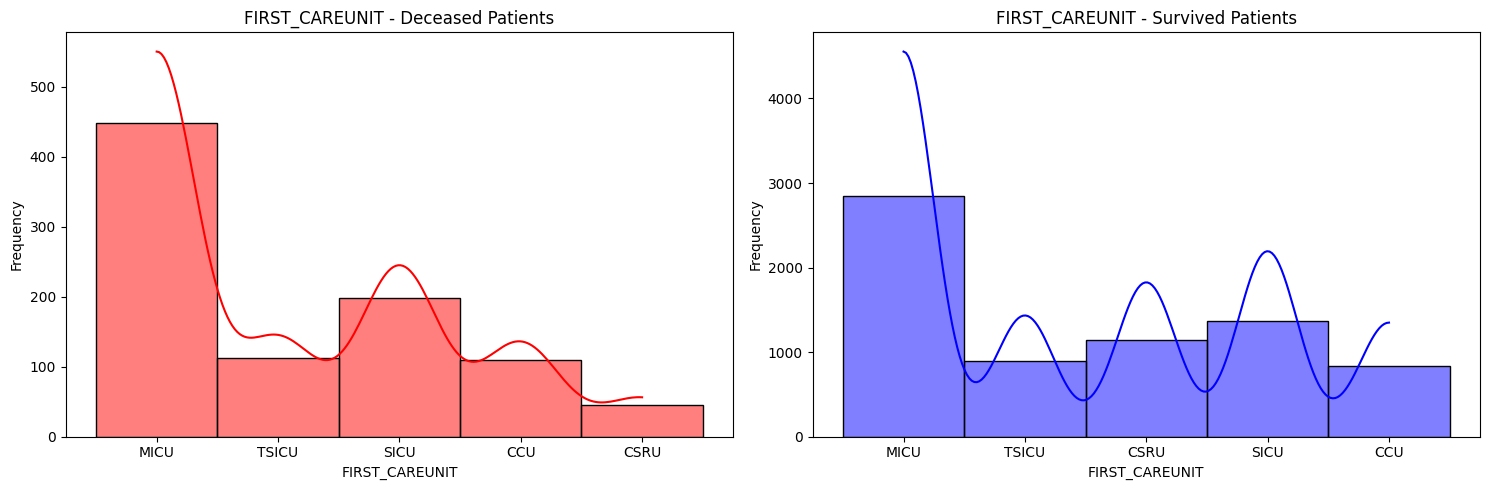

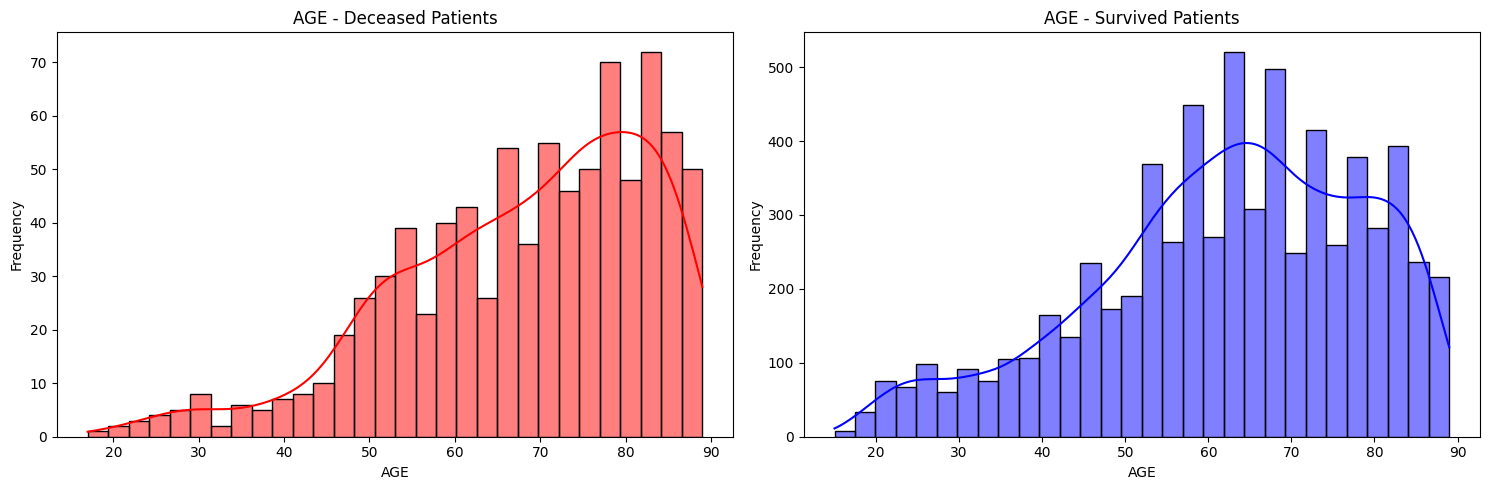

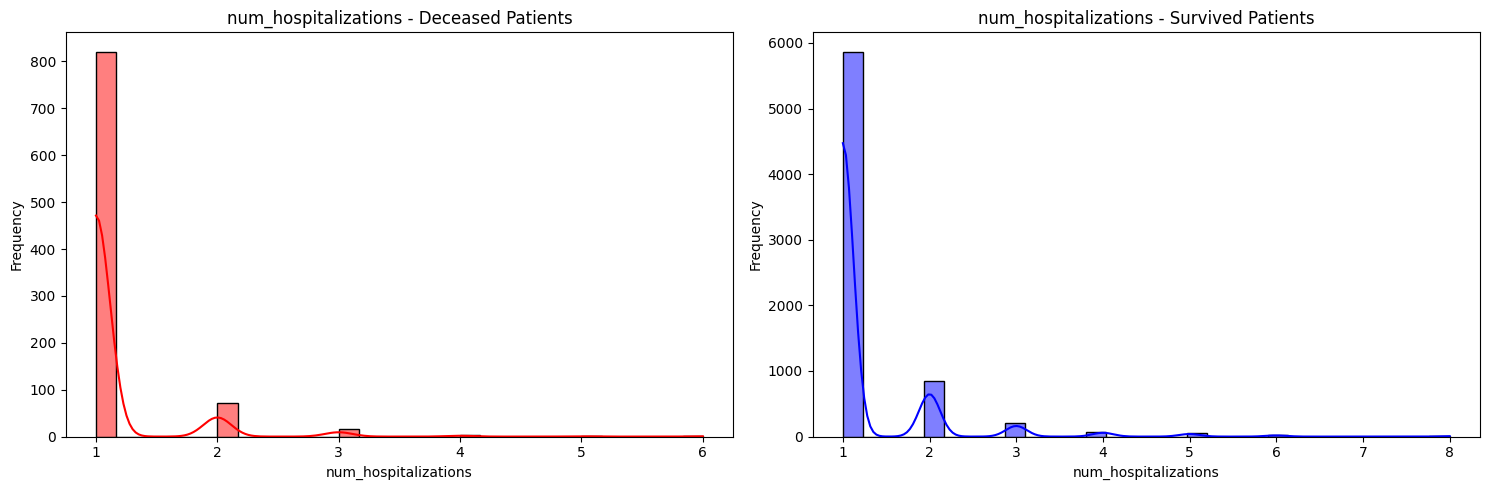

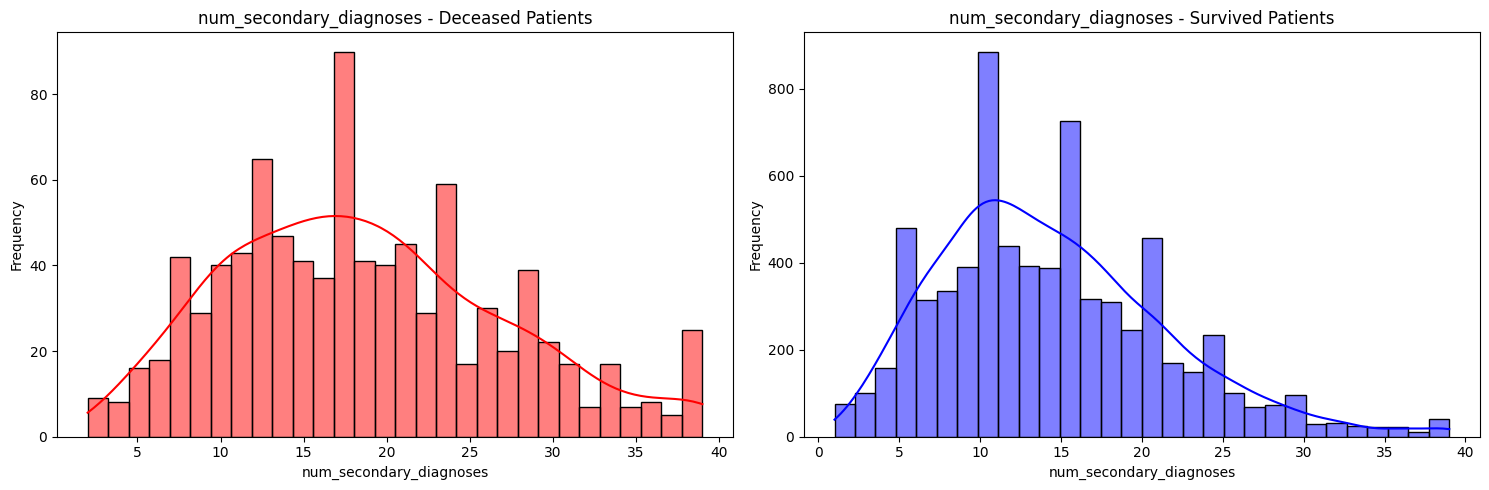

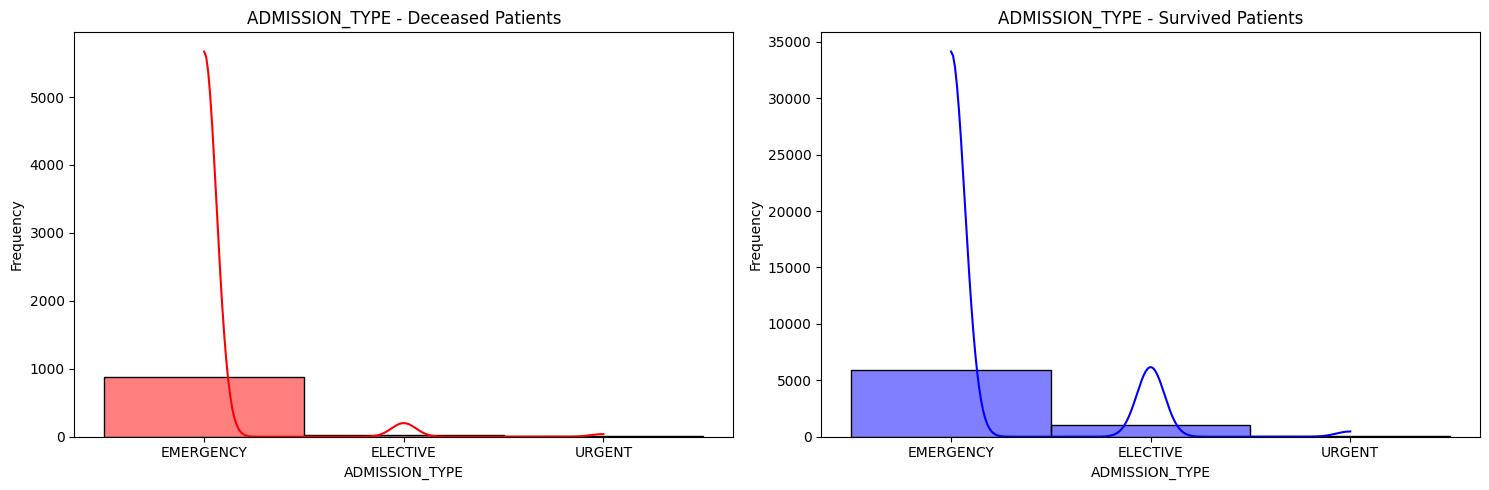

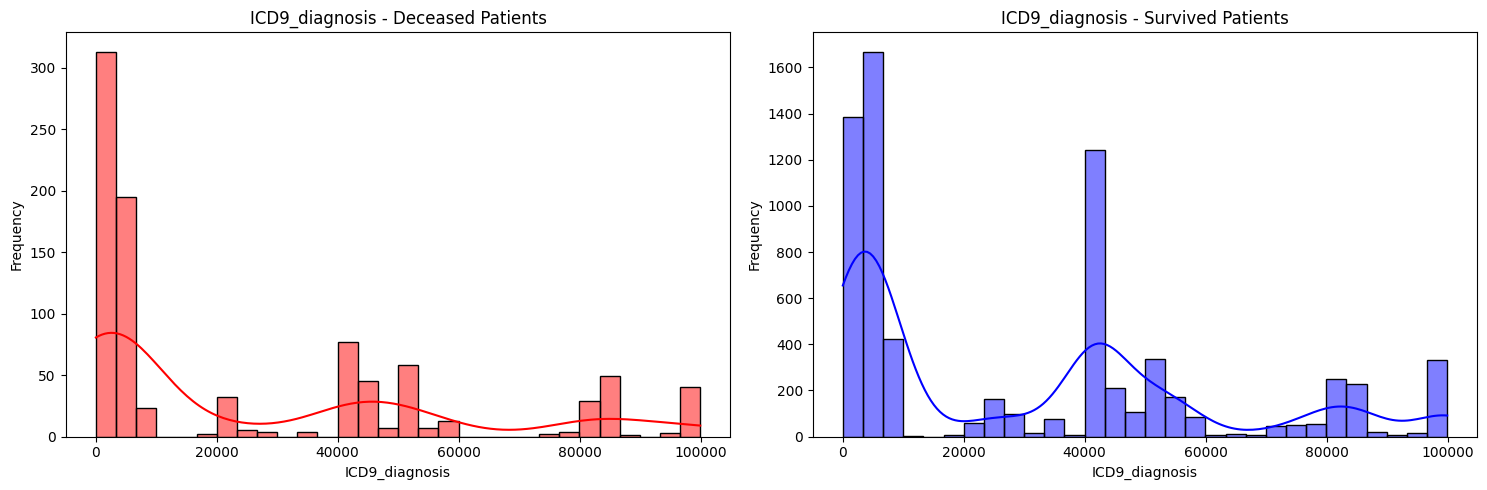

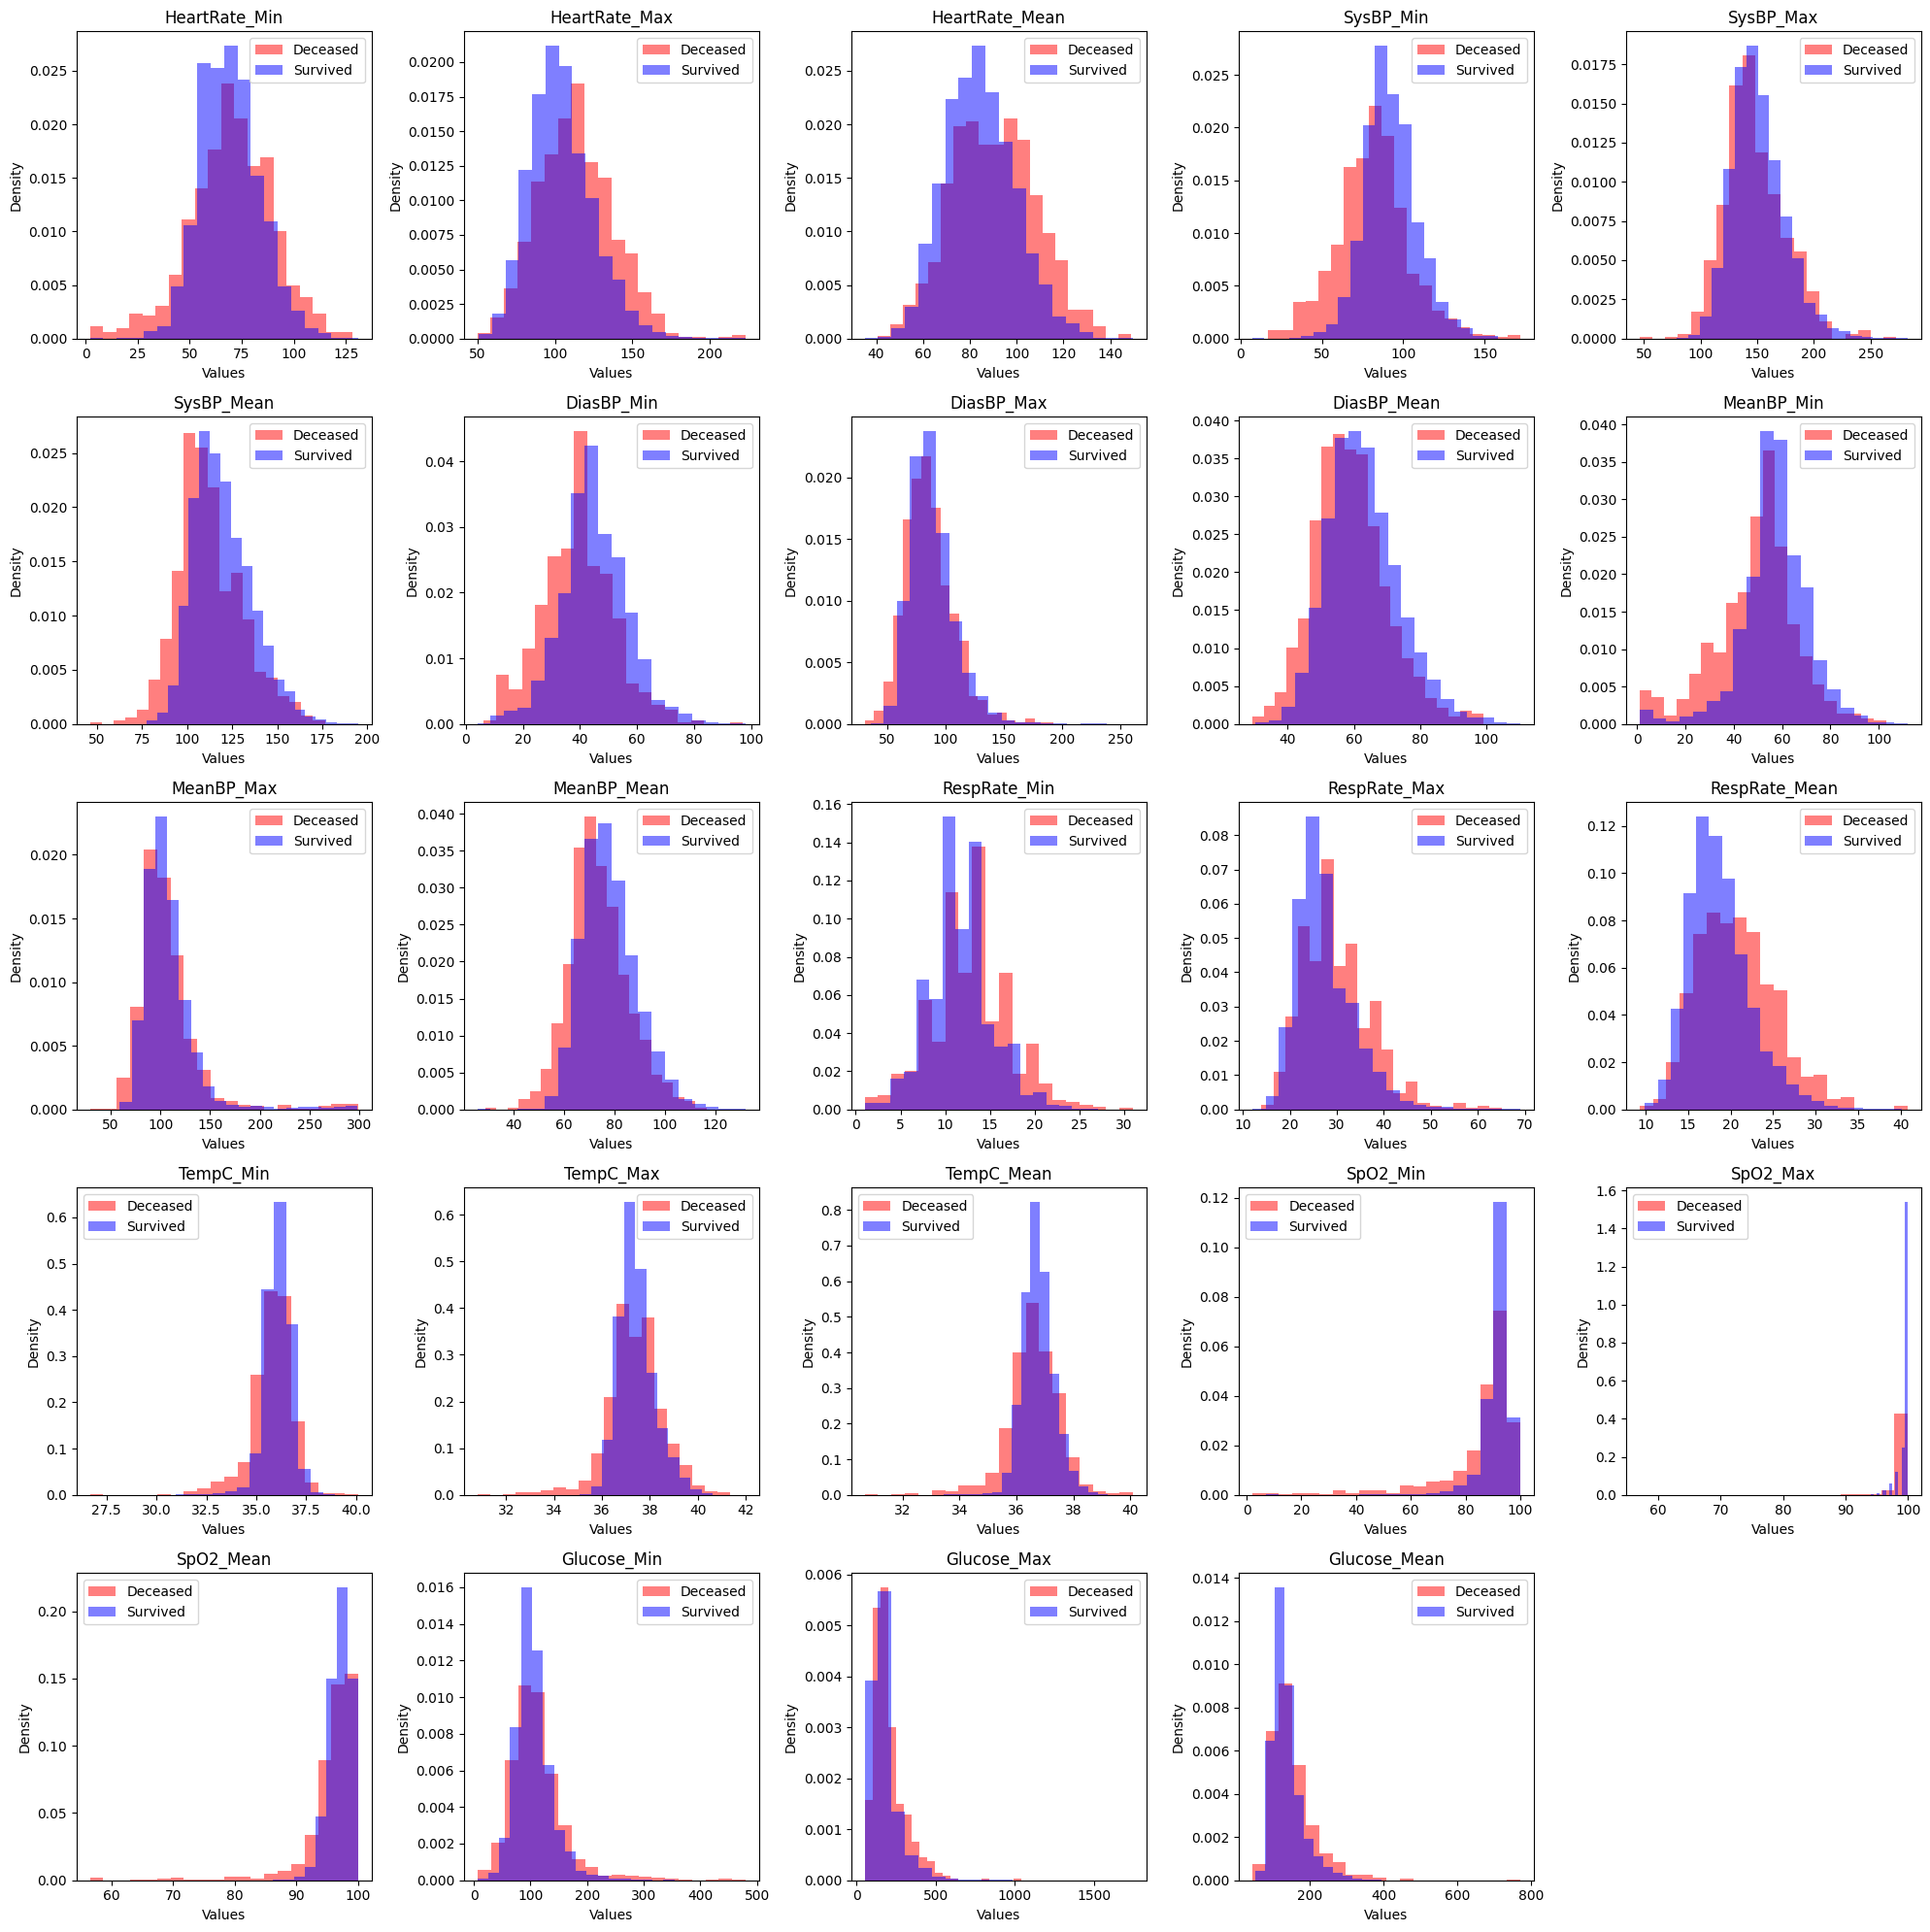

In [ ]:
# Visualize how variables are differently distributed between the two subgroups 
def plot_variable_distribution(deceased, survived, variables):
    for var in variables:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot for deceased patients
        sns.histplot(data=deceased, x=var, bins=30, kde=True, color='red', ax=ax1)
        ax1.set_title(f'{var} - Deceased Patients')
        ax1.set_xlabel(var)
        ax1.set_ylabel('Frequency')
        
        # Plot for survived patients
        sns.histplot(data=survived, x=var, bins=30, kde=True, color='blue', ax=ax2)
        ax2.set_title(f'{var} - Survived Patients')
        ax2.set_xlabel(var)
        ax2.set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Variables to plot 
variables_to_plot = [
    'FIRST_CAREUNIT',
    'AGE',
    'num_hospitalizations',
    'num_secondary_diagnoses',
    'ADMISSION_TYPE',
    'ICD9_diagnosis']

plot_variable_distribution(deceased, survived, variables_to_plot)

def plot_numeric_distributions(deceased, survived, numeric_cols, cols_per_row=5):
    total_columns = len(numeric_cols)
    num_rows = (total_columns + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 4 * num_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        # Plot deceased patients in red
        deceased[col].plot(kind='hist', ax=axes[i], alpha=0.5, color='red', 
                         density=True, label='Deceased', bins=20)
        
        # Plot survived patients in blue on the same axis
        survived[col].plot(kind='hist', ax=axes[i], alpha=0.5, color='blue', 
                         density=True, label='Survived', bins=20)
        
        axes[i].set_title(col)
        axes[i].set_xlabel("Values")
        axes[i].set_ylabel("Density")
        axes[i].legend()
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

numeric_cols = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 
                'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 
                'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 
                'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 
                'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
                'TempC_Min', 'TempC_Max', 'TempC_Mean', 
                'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 
                'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']

plot_numeric_distributions(deceased, survived, numeric_cols)

In [ ]:
# As shown in the corresponding histogram, there is a peak in one specific diagnosis for the deceased subset, 
# so I retrieve the specific code in order to define the 'high_risk_profile' dummy 
deceased['ICD9_diagnosis'].value_counts()

ICD9_diagnosis
389      111
431       64
51881     37
486       21
5070      20
        ... 
20050      1
9726       1
42732      1
7020       1
99664      1
Name: count, Length: 292, dtype: int64

In [ ]:
# Further analyzing the AGE column
print("Age mode of deceased patients")
print(deceased['AGE'].mode())

print("Age mode of survived patients")
print(survived['AGE'].mode())

Age mode of deceased patients
0    74.0
1    86.0
Name: AGE, dtype: float64
Age mode of survived patients
0    62.0
Name: AGE, dtype: float64


Based on the distribution plots, I identified several significant patterns distinguishing deceased from survived patients:

1. Age Distribution
   - deceased patients: bimodal distribution with peaks at 74 and 86 years
   - survived patients: unimodal distribution centered at 62 years
   - Age above 74 years appears to be a significant risk factor
   
   Mode was chosen over mean/median for robustness against outliers

2. Admission Type
   - deceased patients: strong predominance of non-elective admissions
   - survived patients: few elective admissions
   
   While the difference is less pronounced than other factors, including this variable improved the overall predictive power.

3. Secondary Diagnoses
   - deceased patients: higher number of concurrent diagnoses
   - survived patients: generally fewer secondary diagnoses
   
   Logic similar to age distribution in terms of separation between groups.

4. Primary Diagnosis
   ICD9 Code 389 (Septicemia) shows distinctive pattern:
   - pronounced peak in deceased group
   - minimal presence in survived group

5. Vitals
   Critical thresholds identified:
   - Heart Rate < 25
   - Temperature > 35C
   
   Both of these vitals are clear indicators of a potentially fatal condition.

These findings explain my feature selection for the high-risk profile classification that I define below. 


In [ ]:
# Define a dummy for the 'high risk profile' - at least two of the following conditions have to be verified
data['high_risk_profile'] = (
    (data['AGE'] > 74).astype(int) +
    (data['ADMISSION_TYPE'] != 'ELECTIVE').astype(int) + 
    (data['num_secondary_diagnoses'] > 15).astype(int) + 
    (data['ICD9_diagnosis'].isin(['389'])).astype(int) +
    ((data['HeartRate_Min'] >= 0) & (data['HeartRate_Min'] <= 25)).astype(int) +
    ((data['TempC_Max'] >= 0) & (data['TempC_Max'] <= 35)).astype(int)
    >= 2
).astype(int)

test['high_risk_profile'] = (
    (test['AGE'] > 74).astype(int) + 
    (test['ADMISSION_TYPE'] != 'ELECTIVE').astype(int) + 
    (test['num_secondary_diagnoses'] > 15).astype(int) + 
    (test['ICD9_diagnosis'].isin(['389'])).astype(int) +
    ((test['HeartRate_Min'] >= 0) & (test['HeartRate_Min'] <= 25)).astype(int) +
    ((data['TempC_Max'] >= 0) & (data['TempC_Max'] <= 35)).astype(int)
    >= 2
).astype(int)

In [ ]:
# Analyze the dummy we have created 
correct_flags = data[(data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['high_risk_profile'] == 1)].shape[0]
print("\n Number of deceased patients: ", deceased['HOSPITAL_EXPIRE_FLAG'].value_counts()[1])
print("\n Number of high risk profile: ", data['high_risk_profile'].value_counts()[1])
print("\n Number of deceased patients correctly flagged as 'high risk profiles': ", correct_flags)
print("\n Correlation between the two variables of interest:", data['HOSPITAL_EXPIRE_FLAG'].corr(data['high_risk_profile']))


 Number of deceased patients:  913

 Number of high risk profile:  4050

 Number of deceased patients correctly flagged as 'high risk profiles':  703

 Correlation between the two variables of interest: 0.18934006971333486


Similarly to before, there is no perfect correspondence between patients who died and those flagged as `high_risk_profile`, mainly because this dummy variable identifies a significantly larger number of patients as high risk. Despite this, it exhibits a moderate correlation with the target variable, so I kept it, as it ultimately contributed to improving the model's performance.

## 6. Enncode the ICD9_diagnosis basing on mortality 

While I previously converted `ICD9_diagnosis` codes to numeric values for the high-risk profile flag, the raw numeric codes don't directly capture mortality risk. I enhance this feature by encoding this variable into the new `ICD9_diagnosis_encoded`. For each diagnosis code, I calculate the associated mortality rate (as proportion of deaths). In this way each ICD9 code will be transformed into a risk score between 0 and 1. After this calculation, I apply the mortality rates computed on the training set to the corresponding codes in the test set. 
Transforming the categorical `ICD9_diagnosis` into a continuous variable makes it more informative for the mortality prediction.

In [ ]:
# Compute the average mortality for each diagnosis code 
icd9_mortality = data.groupby("ICD9_diagnosis")["HOSPITAL_EXPIRE_FLAG"].mean()

# Create the new feature 
data["ICD9_diagnosis_encoded"] = data["ICD9_diagnosis"].map(icd9_mortality)

# Replace NA with the average mortality 
global_mortality = data["HOSPITAL_EXPIRE_FLAG"].mean()
data["ICD9_diagnosis_encoded"].fillna(global_mortality, inplace=True)

# Apply the same to the test set
test["ICD9_diagnosis_encoded"] = test["ICD9_diagnosis"].map(icd9_mortality)
test["ICD9_diagnosis_encoded"].fillna(global_mortality, inplace=True)

# Analyze the variable that has been created 
print("\n Correlation between the HOSPITAL_EXPIRE_FLAG and the encoded diagnosis:", data['HOSPITAL_EXPIRE_FLAG'].corr(data['ICD9_diagnosis_encoded']))


 Correlation between the HOSPITAL_EXPIRE_FLAG and the encoded diagnosis: 0.4720148189463633


After encoding the `ICD9_diagnosis`, I use the 'diagnoses' dataset to retrieve the co-occurrent diseases. Indeed, analyzing all the comorbidities might give a better insight on the probability that this patient has to die. 
Given the average mortality of each diagnoses, I create three new features:
- `mortality_comorbidities_mean`: average mortality rate across all comorbidities. It gives an overall risk level for the patient's combination of
conditions, and smooths the impact of individual diagnoses.
- `mortality_comorbidities_sum`: cumulative risk that comes from multiple conditions.
- `mortality_comorbidities_max`: takes the condition that has the highest mortality rate among all the comorbidities. 

In [ ]:
# Merge diagnoses dataset with main dataset to compute the mean mortality given the secondary diagnoses
mortality_comorbidities = diagnoses.merge(
    data[['subject_id', 'hadm_id', 'HOSPITAL_EXPIRE_FLAG']],
    left_on='HADM_ID',
    right_on='hadm_id',
    how='left'
).groupby('ICD9_CODE')['HOSPITAL_EXPIRE_FLAG'].mean()

diagnoses['mortality_comorbidities'] = diagnoses['ICD9_CODE'].map(mortality_comorbidities)

# Fill missing values with the general mortality (mean moartality given that a person has entered the Intensive Care Unit)
general_mortality = data['HOSPITAL_EXPIRE_FLAG'].mean()
diagnoses['mortality_comorbidities'] = diagnoses['mortality_comorbidities'].fillna(general_mortality)

# Compute aggregate statistics (mean, sum, max) for comorbidities for each hospital admission
comorbidity_stats = diagnoses.groupby('HADM_ID').agg(
    mortality_comorbidities_mean=('mortality_comorbidities', 'mean'),
    mortality_comorbidities_sum=('mortality_comorbidities', 'sum'),
    mortality_comorbidities_max=('mortality_comorbidities', 'max')
).reset_index()

# Add these new columns to both the datasets
data = data.merge(comorbidity_stats, left_on='hadm_id', right_on='HADM_ID', how='left')
test = test.merge(comorbidity_stats, left_on='hadm_id', right_on='HADM_ID', how='left')

# Fill missing values in aggregated features with 0 (for cases with no diagnoses)
data[['mortality_comorbidities_mean', 'mortality_comorbidities_sum', 'mortality_comorbidities_max']] = \
    data[['mortality_comorbidities_mean', 'mortality_comorbidities_sum', 'mortality_comorbidities_max']].fillna(0)

test[['mortality_comorbidities_mean', 'mortality_comorbidities_sum', 'mortality_comorbidities_max']] = \
    test[['mortality_comorbidities_mean', 'mortality_comorbidities_sum', 'mortality_comorbidities_max']].fillna(0)
    
# Analyze the variables that have been created 
print("\n Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_mean:", 
      data['HOSPITAL_EXPIRE_FLAG'].corr(data['mortality_comorbidities_mean']))

print("\n Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_sum:", 
      data['HOSPITAL_EXPIRE_FLAG'].corr(data['mortality_comorbidities_sum']))

print("\n Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_max:", 
      data['HOSPITAL_EXPIRE_FLAG'].corr(data['mortality_comorbidities_max']))


 Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_mean: 0.6001644296762249

 Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_sum: 0.4662535192946571

 Correlation between the HOSPITAL_EXPIRE_FLAG and mortality_comorbidities_max: 0.5666727688338661


## 7. Remove unnecessary columns - some of them come from intermediate manipulations

In [ ]:
# Remove unnecessary columns 
data = data.drop(['subject_id','hadm_id', 'DOD', 'DISCHTIME', 'DEATHTIME', 'RELIGION', 'LOS', 'Unnamed: 0', 'ADMITTIME',
                  'SHORT_DIAGNOSE', 'LONG_DIAGNOSE', 'LONG_DIAGNOSE_cleaned', 'DIAGNOSIS', 'DIAGNOSIS_cleaned', 'Diff',  
                  'DOB', 'secondary_diagnoses', 'MARITAL_STATUS', 'ICD9_diagnosis', 'HADM_ID', 'ETHNICITY'], axis=1)

# Remove unnecessary columns 
test = test.drop(['subject_id','hadm_id', 'DOD', 'DISCHTIME', 'DEATHTIME', 'RELIGION', 'LOS', 'Unnamed: 0', 'ADMITTIME',
                  'SHORT_DIAGNOSE', 'LONG_DIAGNOSE', 'LONG_DIAGNOSE_cleaned', 'DIAGNOSIS', 'DIAGNOSIS_cleaned', 'Diff',  
                  'DOB', 'secondary_diagnoses', 'MARITAL_STATUS', 'ICD9_diagnosis', 'HADM_ID', 'ETHNICITY'], axis=1)

## 8. Apply one-hot encoding to relevant categorical features 

In [ ]:
# One hot encoding for categorical variables - both datasets 
data = pd.get_dummies(data, prefix=['GENDER'], columns=['GENDER'], drop_first=True)
data = pd.get_dummies(data, prefix=['ADMISSION_TYPE'], columns=['ADMISSION_TYPE'], drop_first=True)
data = pd.get_dummies(data, prefix=['FIRST_CAREUNIT'], columns=['FIRST_CAREUNIT'], drop_first=True)
data = pd.get_dummies(data, prefix=['INSURANCE'], columns=['INSURANCE'], drop_first=True)

test = pd.get_dummies(test, prefix=['GENDER'], columns=['GENDER'], drop_first=True)
test = pd.get_dummies(test, prefix=['ADMISSION_TYPE'], columns=['ADMISSION_TYPE'], drop_first=True)
test = pd.get_dummies(test, prefix=['FIRST_CAREUNIT'], columns=['FIRST_CAREUNIT'], drop_first=True)
test = pd.get_dummies(test, prefix=['INSURANCE'], columns=['INSURANCE'], drop_first=True)

## 9. KNN imputation for missing values 

In [ ]:
# Define the columns with missing values
columns_to_impute = [
    'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
    'SysBP_Min', 'SysBP_Max', 'SysBP_Mean',
    'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
    'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
    'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
    'TempC_Min', 'TempC_Max', 'TempC_Mean',
    'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
    'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
    'AGE', 'ICD9_diagnosis_encoded'
]

# Create copies to avoid modifying original data
train_copy = data.copy()
test_copy = test.copy()

# Initialize the scaler
scaler = StandardScaler()

# Scale the features for better KNN performance
train_scaled = scaler.fit_transform(data[columns_to_impute])
test_scaled = scaler.transform(test[columns_to_impute])

# Convert to dataframes
train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_impute)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_impute)

# Set the seed for reproducibility 
random.seed(123)

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Fit on training data and transform both datasets
train_imputed = imputer.fit_transform(train_scaled_df)
test_imputed = imputer.transform(test_scaled_df)

# Convert back to original scale
train_imputed = scaler.inverse_transform(train_imputed)
test_imputed = scaler.inverse_transform(test_imputed)

# Convert to dataframes
train_imputed_df = pd.DataFrame(train_imputed, columns=columns_to_impute)
test_imputed_df = pd.DataFrame(test_imputed, columns=columns_to_impute)

# Update the original dataframes with imputed values
data[columns_to_impute] = train_imputed_df
test[columns_to_impute] = test_imputed_df

## 10. Implement SVM with Ensemble and general comments 

Given that in this notebook all the intermediate steps are not visible, I would like to briefly describe the methodology I implemented and the reasoning behind my choices.

### **Feature Selection:**
- Initially, I attempted to remove variables that did not have an apparent logical relationship with the probability of mortality in the Intensive Care Unit. However, my initial results were suboptimal. To refine the model, I incrementally reintroduced features, assessing their impact one at a time.
- **Categorical Features:** `MARITAL_STATUS` and `ETHNICITY` were mapped into broader categories and then one-hot encoded, as they enhanced predictive performance. I tested the same approach for `RELIGION`, but it only introduced noise without improving accuracy, so it was excluded.
- **Temporal Features:** I hypothesized that the admission day of the week might provide insight into the nature of the admission. For example:
  - Differences in traffic levels on weekdays vs. weekends might impact the severity of car accidents.
  - Variations in hospital staffing levels over the weekend could influence patient outcomes.
  
  I first tested only the binary `IS_WEEKEND_ADMISSION`, and later added information such as `ADMISSION_YEAR`. These additional features increased predictive power, so I retained all relevant temporal data extracted from the `ADMITTIME` column.

### **Feature Engineering:**
- **`selected_words` dummy:**
  - This feature efficiently use all available textual data in a way that is compatible across different models. Since only LightGBM handles textual features, other base learners would have required dropping these columns. Instead, I processed the text data to extract meaningful information usable by all models.
- **`high_risk_profile` dummy:**
  - This feature identifies patterns between specific variable combinations and mortality probability. It flags patients at high risk based on five medical conditions, requiring at least two criteria to be met.
  - While machine learning algorithms inherently detect such patterns, explicitly flagging critical risk factors further improved model performance.

### **Model Implementation:**
Initially, I implemented SVM without hyperparameter tuning to enable quick submissions while refining the dataset. After optimizing feature selection and engineering, I selected four base learners based on their complementary strengths:
  1. **Support Vector Machine (SVM)** – Well-suited for high-dimensional feature spaces and robust to outliers.
  2. **Random Forest (RF)** – Highly efficient in capturing non-linear relationships.
  3. **XGBoost (XGB)** – Highly efficient gradient boosting with built-in regularization to prevent overfitting.
  4. **LightGBM (LGBM)** – Optimized for speed and large datasets, excelling in handling categorical variables.

### **Ensemble Strategy: Soft Voting vs. Stacking**
- I experimented with **Stacking** (where a meta-model learns from base learners’ predictions), but it slightly underperformed compared to Soft Voting.
I think that, in this specific case, Soft Voting was superior because:
  - aggregates probability distributions, and so captures more information than hard voting.
  - reduces model variance, leading to more stable predictions.
  - balances individual model weaknesses by leveraging diverse decision-making approaches.

- Stacking performed worse because:
  - the meta-model introduced additional variance, leading to overfitting on validation data.
  - the base learners already had strong individual performances, making stacking less beneficial in this specific scenario.

### **Parameters selection**
To select the parameters to test for each model's optimization, I based my choice on previous trials and best practices, considering the dataset's characteristics and a good balance between model complexity and generalization.

**SVM Parameters:**
- **C: [0.5, 1, 1.5]** controls the trade-off between a simpler (high regularization) and more flexible decision boundary. A narrow range is chosen since higher values did not improve performance in previous tests.
- **kernel: ['rbf']** the Radial Basis Function (RBF) kernel is selected because it outperformed both the linear and polynomial kernels in past trials, as expected for non-linearly separable data.
- **gamma: ['scale', 'auto', 0.001, 0.01, 0.1]** defines how far each training example influences the decision boundary. A mix of adaptive (scale, auto) and manually defined values allows better control over model flexibility.
- **class_weight: ['balanced']** adjusts weights to counteract class imbalance, ensuring the minority class has a stronger influence during training.

**Random Forest Parameters:**
- **n_estimators: [100 to 1000]** the number of trees is chosen to ensure model stability. A higher number improves robustness, but beyond a certain point, it doesn't. This range should guarantee stability given the number of feature I have.
- **max_depth: [5 to None]** limits tree complexity to prevent overfitting. A depth of 5 captures basic feature interactions, while None allows trees to grow fully.
- **min_samples_split/leaf** controls the minimum number of samples needed to create a new split or leaf. Higher values prevent overfitting by enforcing more general splits.

**XGBoost Parameters:**
- **learning_rate: [0.01 to 0.3]** a conservative range to balance convergence speed and stability. Lower values ensure smooth learning, while higher values allow faster training.
- **max_depth: [3 to 9]**  restricts tree depth to prevent overfitting while capturing essential feature interactions.
- **subsample/colsample: [0.6 to 1.0]** introduces randomness in sample and feature selection, improving generalization and reducing model variance.

**LightGBM Parameters:**
- **learning_rate: [0.01 to 0.1]** a conservative range for stable learning, preventing extreme weight updates that could lead to overfitting.
- **num_leaves: [31 to 100]** controls tree complexity. Higher values increase flexibility but must be balanced with regularization to avoid overfitting.
- **reg_alpha/lambda** apply L1 (Lasso) and L2 (Ridge) regularization, respectively, to reduce overfitting by penalizing overly complex models.

In [ ]:
# Deactivate warning messages 
lgb.log_evaluation(False)  
xgb.set_config(verbosity=0)

# Save icustay_id separetly and divide between target variable and predictors 
icustay_ids_train = data['icustay_id']
X = data.drop(columns=['HOSPITAL_EXPIRE_FLAG', 'icustay_id']) 
y = data['HOSPITAL_EXPIRE_FLAG'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the training dataset into train and test to 
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X_scaled, y, icustay_ids_train, test_size=0.2, random_state=42, stratify=y)

# Oversampling with SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

# Convert to numpy array 
X_train_bal = np.array(X_train_bal)
X_test = np.array(X_test)
y_train_bal = np.array(y_train_bal)
y_test = np.array(y_test)

#  SVM
svm_params = {'C': [0.5, 1, 1.5], 'kernel': ['rbf'], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], 'class_weight': ['balanced']}
svm_grid = RandomizedSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='accuracy', n_iter=20, n_jobs=-1)
svm_grid.fit(X_train_bal, y_train_bal)
print(f"Best parameters SVM: {svm_grid.best_params_}")
svm_refined = GridSearchCV(
    SVC(probability=True, random_state=42), 
    {'C': [svm_grid.best_params_['C'] * 0.5, svm_grid.best_params_['C'], svm_grid.best_params_['C'] * 1.5]}, 
    cv=5, scoring='accuracy', n_jobs=-1)
svm_refined.fit(X_train_bal, y_train_bal)

#  Random Forest
rf_params = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'bootstrap': [True, False]}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_iter=20, n_jobs=-1)
rf_grid.fit(X_train_bal, y_train_bal)
print(f"Best parameters RF: {rf_grid.best_params_}")

#  XGBoost
xgb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 5]}
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='roc_auc', n_iter=20, n_jobs=-1)
xgb_grid.fit(X_train_bal, y_train_bal)
print(f"Best parameters XGB: {xgb_grid.best_params_}")

#  LightGBM
lgb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]}
lgb_grid = RandomizedSearchCV(lgb.LGBMClassifier(), lgb_params, cv=5, scoring='roc_auc', n_iter=20, n_jobs=-1)
lgb_grid.fit(X_train_bal, y_train_bal)
print(f"Best parameters LGB: {lgb_grid.best_params_}")

# Combine previously trained models to create the ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('svm', SVC(**svm_refined.best_params_, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(**rf_grid.best_params_, random_state=42)),
        ('xgb', xgb.XGBClassifier(**xgb_grid.best_params_, eval_metric='logloss', random_state=42)),
        ('lgb', lgb.LGBMClassifier(**lgb_grid.best_params_, random_state=42))],voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_bal, y_train_bal)

# Make predictions on the train set and print the accuracy 
y_pred_test = ensemble_model.predict(X_test)
y_prob_test = ensemble_model.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

# Make predictions for the test set
test_without_id = test.drop(columns=['icustay_id'])
test_scaled = scaler.transform(test_without_id)
test_predictions = ensemble_model.predict_proba(test_scaled)[:, 1]

# Create the submission file and print the accuracy on the test set 
submission = pd.DataFrame({
    "icustay_id": test["icustay_id"],  
    "HOSPITAL_EXPIRE_FLAG": test_predictions})
submission.to_csv("submission_Noemi_final.csv", index=False) 
print(f"Accuracy on validation set: {accuracy_score(y_test, y_pred_test):.4f}")

Best parameters SVM: {'kernel': 'rbf', 'gamma': 0.1, 'class_weight': 'balanced', 'C': 1.5}
Best parameters RF: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': False}
Best parameters XGB: {'subsample': 0.6, 'scale_pos_weight': 3, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536[LightGBM] [Info] Number of positive: 4536, number of negative: 4536

[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] N

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[L

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive ga

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12758
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12262
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 12418
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4536, number of negative: 4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12258
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5670, number of negative: 5670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12782
[LightGBM] [Info] Number of data points in the train set: 11340, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split